## Step 2: Scouting Research Candidates

Decision whether or not to pursue a research item

In [ ]:
import sys
sys.path.append('../')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

from components.agents.scout_agent import scout_batch

Load Research Items

In [11]:
df = pd.read_csv("../data/research_items.csv")

provider_counts = df['provider'].value_counts()
print("Absolute counts:")
print(provider_counts)
print("\nNormalized (proportions):")
print(df['provider'].value_counts(normalize=True))

Absolute counts:
provider
arxiv        3126
openai        447
anthropic     377
exa           252
Name: count, dtype: int64

Normalized (proportions):
provider
arxiv        0.743931
openai       0.106378
anthropic    0.089719
exa          0.059971
Name: proportion, dtype: float64


In [12]:
df.iloc[2:6]

,focus_area,provider,url,title,source,published,relevance,date_added,scout_decision,scout_confidence,scout_reasoning,scouted_at
2,reasoning_agent,openai,https://openai.com/index/gpt-5-2-codex,Introducing GPT-5.2-Codex,OpenAI blog,2025-12-18,Official release of an agentic coding model em...,2025-12-24,pursue,0.93,"This is an official OpenAI release (credible, ...",2025-12-26T23:51:12.380414
3,reasoning_agent,openai,https://openai.com/index/introducing-gpt-5-2/,Introducing GPT-5.2,OpenAI blog,2025-12-11,Details GPT-5.2 “Thinking/Pro” modes and API r...,2025-12-24,pursue,0.93,This is a recent (2025-12-11) primary-source r...,2025-12-26T23:51:12.380718
4,reasoning_agent,openai,https://blog.google/products/gemini/gemini-3/,Introducing Gemini 3: our most intelligent mod...,Google Blog (Gemini/DeepMind),2025-11-18,Announces Gemini 3 with “thinking”/Deep Think ...,2025-12-24,pursue,0.86,"This is a very recent, high-signal primary-sou...",2025-12-26T23:51:12.380975
5,reasoning_agent,openai,https://www.anthropic.com/engineering/equippin...,Equipping agents for the real world with Agent...,Anthropic Engineering,2025-10-16 (updated 2025-12-18),Introduces (and updates) a modular skills syst...,2025-12-24,pursue,0.90,This is directly relevant to our core needs (t...,2025-12-26T23:51:12.381219


Select items that have not yet been looked at

In [ ]:
pending = df[df["scout_decision"].isna() | df["scout_reasoning"].str.startswith("ERROR:", na=False)]

In [20]:
# Collect scout items
items_to_scout = pending.to_dict("records")
print(f"Number of items to scout: {len(items_to_scout)}")

Number of items to scout: 1


Run Scouting

In [24]:
decisions = await scout_batch(
    items=items_to_scout, 
    batch_size=400
)

2025-12-27 22:38:25,414 - components.agents.scout_agent - INFO - Processing batch 1/1 (1 items)
Scout batch 1/1:   0%|          | 0/1 [00:00<?, ?it/s]2025-12-27 22:38:48,217 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 400 Bad Request"
2025-12-27 22:38:48,219 - openai.agents - ERROR - Error getting response: Error code: 400 - {'error': {'message': "Invalid prompt: we've limited access to this content for safety reasons. This type of information may be used to benefit or to harm people. We are continuously refining our work in this area, and you can read more about our approach in our blog post (https://openai.com/index/preparing-for-future-ai-capabilities-in-biology) and Model Spec (https://openai.com/index/introducing-the-model-spec).", 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_prompt'}}. (request_id: req_9c00bf6e23f24858b882ea6edae0177b)
Scout batch 1/1: 100%|██████████| 1/1 [00:22<00:00, 22.80s/it]


Update DataFrame

In [8]:
for i, (idx, row) in enumerate(pending.iterrows()):
    df.loc[idx, "scout_decision"] = "pursue" if decisions[i].pursue else "discard"
    df.loc[idx, "scout_confidence"] = decisions[i].confidence
    df.loc[idx, "scout_reasoning"] = decisions[i].reasoning
    df.loc[idx, "scouted_at"] = datetime.now().isoformat()

In [25]:
df['scout_decision'].value_counts(dropna=False)

scout_decision
pursue     2418
discard    1784
Name: count, dtype: int64

Save back to DF

In [10]:
df.to_csv("../data/research_items.csv", index=False)

Check some pursue vs discard items

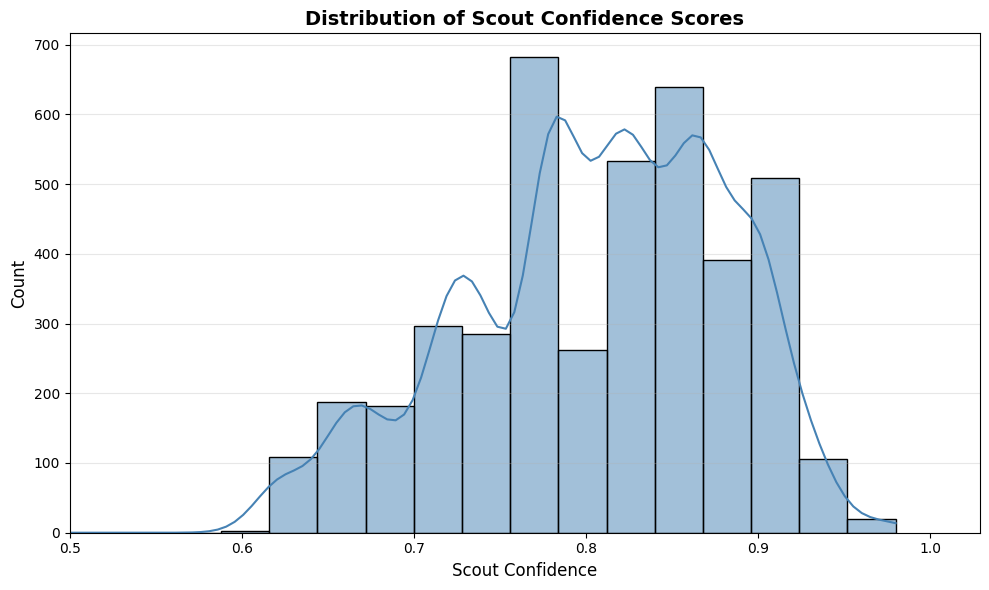

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(df['scout_confidence'], bins=35, kde=True, ax=ax, color='steelblue')
ax.set_xlabel('Scout Confidence', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Scout Confidence Scores', fontsize=14, fontweight='bold')
ax.set_xlim(left=0.5)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [28]:
df[df['scout_confidence'] <= 0.625].head(3)

,focus_area,provider,url,title,source,published,relevance,date_added,scout_decision,scout_confidence,scout_reasoning,scouted_at
374,arxiv,arxiv,https://arxiv.org/abs/2512.20457v1,When Natural Strategies Meet Fuzziness and Res...,arXiv,2025-12-23,Summary: In formal strategic reasoning for Mul...,2025-12-25,pursue,0.62,This is directly in the multi-agent strategic ...,2025-12-26T23:51:12.456143
470,arxiv,arxiv,https://arxiv.org/abs/2512.20094v1,Jensen-Shannon Divergence Message-Passing for ...,arXiv,2025-12-23,"Summary: In this paper, we investigate how the...",2025-12-25,pursue,0.60,This is directly about learning embeddings on ...,2025-12-26T23:51:12.471280
530,arxiv,arxiv,https://arxiv.org/abs/2512.20029v1,$\text{H}^2$em: Learning Hierarchical Hyperbol...,arXiv,2025-12-23,Summary: Compositional zero-shot learning (CZS...,2025-12-25,pursue,0.62,Although framed around compositional zero-shot...,2025-12-26T23:51:12.480877


In [30]:
df[df['scout_decision'] == 'pursue'].iloc[5:10]

,focus_area,provider,url,title,source,published,relevance,date_added,scout_decision,scout_confidence,scout_reasoning,scouted_at
7,reasoning_agent,openai,https://simonwillison.net/2025/Dec/19/agent-sk...,Agent Skills,Simon Willison’s blog,2025-12-19,Technical commentary highlighting implementati...,2025-12-24,pursue,0.82,This is directly relevant to agent infrastruct...,2025-12-26T23:51:12.381906
8,reasoning_agent,openai,https://arxiv.org/abs/2512.02008,The Art of Scaling Test-Time Compute for Large...,arXiv,2025-12-01,Large-scale empirical comparison of test-time ...,2025-12-24,pursue,0.90,This is directly aligned with our need to impr...,2025-12-26T23:51:12.382342
9,reasoning_agent,openai,https://arxiv.org/abs/2512.02304,When Does Verification Pay Off? A Closer Look ...,arXiv,2025-12-02,Systematic solver–verifier study (including cr...,2025-12-24,pursue,0.88,This is directly relevant to improving reliabi...,2025-12-26T23:51:12.382596
10,reasoning_agent,openai,https://arxiv.org/abs/2512.10313,EpiPlanAgent: Agentic Automated Epidemic Respo...,arXiv,2025-12-11 (v2 2025-12-12),Multi-agent LLM workflow for real planning/val...,2025-12-24,pursue,0.80,Even though the application domain is epidemic...,2025-12-26T23:51:12.382985
11,reasoning_agent,openai,https://arxiv.org/abs/2512.17912,Graph-O1 : Monte Carlo Tree Search with Reinfo...,arXiv,2025-11-26,Agentic GraphRAG approach combining MCTS + RL ...,2025-12-24,pursue,0.82,This is directly aligned with our “Reasoning &...,2025-12-26T23:51:12.383250


In [31]:
df[df['scout_decision'] == 'discard'].iloc[5:10]

,focus_area,provider,url,title,source,published,relevance,date_added,scout_decision,scout_confidence,scout_reasoning,scouted_at
140,agents_and_finance,anthropic,https://www.weforum.org/stories/2024/12/agenti...,How Agentic AI will transform financial services,World Economic Forum,December 2024,WEF analysis on agentic AI transforming financ...,2025-12-24,discard,0.80,This looks like a high-level thought-leadershi...,2025-12-26T23:51:12.414812
154,agents_and_finance,anthropic,https://www.v7labs.com/blog/ai-for-private-equ...,5 Applications of AI in Venture Capital and Pr...,V7 Labs,recent,Survey shows 82% of PE/VC firms using AI in Q4...,2025-12-24,discard,0.82,This looks like a high-level “applications” ro...,2025-12-26T23:51:12.417244
155,agents_and_finance,anthropic,https://www.affinity.co/guides/vc-ai-tools,10 AI Tools for Venture Capital Firms in 2025,Affinity,2025,"Guide to AI-powered deal sourcing, relationshi...",2025-12-24,discard,0.72,"This looks like a vendor-authored, top-10 styl...",2025-12-26T23:51:12.417419
159,agents_and_finance,anthropic,https://www.highradius.com/resources/Blog/agen...,How Agentic AI Enhances Financial Reporting: 5...,HighRadius,April 2025,Practical guide on AI agents for journal entry...,2025-12-24,discard,0.78,While the topic (agentic AI for financial repo...,2025-12-26T23:51:12.418105
165,agents_and_finance,anthropic,https://learn.deeplearning.ai/courses/multi-ai...,Multi AI Agent Systems with CrewAI - Financial...,DeepLearning.AI,May 2024,Educational course on building multi-agent fin...,2025-12-24,discard,0.78,While multi-agent financial analysis is direct...,2025-12-26T23:51:12.419227
